In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

### Preprocessing data

In [2]:
data_c = pd.read_parquet('./Local/2017_Clean/Combined.parquet')
data_f1 = pd.read_parquet('./Local/2017_Final/Combined_1.parquet')
data_f2 = pd.read_parquet('./Local/2017_Final/Combined_2.parquet')

datasets = {'Clean data': data_c, 'Final data 1': data_f1, 'Final data 2': data_f2}

In [3]:
def preprocess_data(df):
    label_encoder = LabelEncoder()
    
    if 'Label' in df.columns:
        label_col = 'Label'
    elif ' Label' in df.columns:
        label_col = ' Label'
    else:
        raise ValueError("DataFrame does not contain a label column")
    
    df[label_col] = label_encoder.fit_transform(df[label_col])
    
    X = df.drop(label_col, axis=1)
    y = df[label_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

processed_datasets = {name: preprocess_data(df) for name, df in datasets.items()}

## First approach

### Building Autoencoder with TensorFlow/Keras

Encoder:
- The encoder compresses the input data into a lower-dimensional representation.
- It consists of four Dense layers, progressively reducing the dimensionality (input_dim -> 64 -> 32 -> 16 -> 8).
- Each layer uses ReLU activation.

Decoder:
- Reconstructs the original input from the compressed representation.
- It mirrors the encoder structure, progressively increasing the dimensionality (8 -> 16 -> 32 -> 64 -> input_dim).
- The final layer uses linear activation to allow for any range of output values.

The autoencoder combines the encoder and decoder into a single model.
During training, it learns to reconstruct the input data as closely as possible. 

The autoencoder is compiled with the Adam optimizer and Mean Squared Error (MSE) loss.

In [4]:
def build_autoencoder(input_dim):
    encoder = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu')
    ])
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(input_dim, activation='linear')
    ])
    
    autoencoder = tf.keras.Sequential([encoder, decoder])
    return autoencoder


def train_autoencoder(X_train, epochs=50, batch_size=32):
    input_dim = X_train.shape[1]
    autoencoder = build_autoencoder(input_dim)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        shuffle=True
    )
    
    return autoencoder, history

def detect_anomalies(autoencoder, X, threshold):
    reconstructed = autoencoder.predict(X)
    mse = np.mean(np.power(X - reconstructed, 2), axis=1)
    return mse > threshold

### Running Autoencoder for each dataset

In [5]:
for name, (X_train, X_test, y_train, y_test) in processed_datasets.items():
    autoencoder, history = train_autoencoder(X_train)

    threshold = np.percentile(history.history['loss'], 95)  # Using 95th percentile of training loss as threshold
    anomalies = detect_anomalies(autoencoder, X_test, threshold)

    true_positives = np.sum((anomalies == 1) & (y_test == 1))
    false_positives = np.sum((anomalies == 1) & (y_test == 0))
    true_negatives = np.sum((anomalies == 0) & (y_test == 0))
    false_negatives = np.sum((anomalies == 0) & (y_test == 1))
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f'--- {name} ---')
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")

/run/media/arzaca/Maxtor/Network-Anomaly-Detection/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1723454772.618568   68015 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723454774.718498   68015 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723454774.

Epoch 1/50


I0000 00:00:1723454781.545118   80265 service.cc:146] XLA service 0x71ab9c0058c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723454781.545184   80265 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-08-12 11:26:22.332552: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-12 11:26:23.336130: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  213/51453 ━━━━━━━━━━━━━━━━━━━━ 36s 710us/step - loss: 0.7840

I0000 00:00:1723454787.966840   80265 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51453/51453 ━━━━━━━━━━━━━━━━━━━━ 55s 880us/step - loss: 0.1847 - val_loss: 0.1291
Epoch 2/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 41s 800us/step - loss: 0.2925 - val_loss: 0.1730
Epoch 3/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 41s 804us/step - loss: 0.2008 - val_loss: 0.0925
Epoch 4/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 41s 804us/step - loss: 0.2481 - val_loss: 0.1594
Epoch 5/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 41s 805us/step - loss: 0.2042 - val_loss: 0.0952
Epoch 6/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 45s 864us/step - loss: 0.0842 - val_loss: 0.1522
Epoch 7/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 45s 879us/step - loss: 0.1650 - val_loss: 0.1046
Epoch 8/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 43s 840us/step - loss: 0.1033 - val_loss: 0.1277
Epoch 9/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 43s 826us/step - loss: 0.2081 - val_loss: 0.0756
Epoch 10/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 41s 790us/step - loss: 0.0984 - val_loss: 0.0381
Epoch 11/50
51453/51453 ━━━━━━━━━━━━━━━━━━━━ 41s 792us/step - loss: 0.1474 - val

2024-08-12 12:01:10.442070: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 197578740 exceeds 10% of free system memory.


Epoch 1/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 86s 807us/step - loss: 0.1984 - val_loss: 0.0371
Epoch 2/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 81s 782us/step - loss: 0.1628 - val_loss: 0.1184
Epoch 3/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 81s 782us/step - loss: 0.0779 - val_loss: 0.1286
Epoch 4/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 81s 782us/step - loss: 0.0928 - val_loss: 0.0830
Epoch 5/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 80s 781us/step - loss: 0.0849 - val_loss: 0.0561
Epoch 6/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 81s 785us/step - loss: 0.0687 - val_loss: 0.0550
Epoch 7/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 80s 777us/step - loss: 0.0518 - val_loss: 0.0216
Epoch 8/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 80s 778us/step - loss: 0.0647 - val_loss: 0.2614
Epoch 9/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 80s 777us/step - loss: 0.0657 - val_loss: 0.0430
Epoch 10/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 80s 781us/step - loss: 0.0308 - val_loss: 0.1178
Epoch 11/50
102906/102906 ━━━━━━━━━━━━━━━━━━━━ 80

### Second approach

In [17]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt

### Building Autoencoder with Jax/Stax

Encoder:
- The encoder compresses the input data into a 12-dimensional representation.
- It consists of two Dense layers with dimensions: input_dim -> 16 -> 12.
- ReLU activation is used between the layers.

Decoder:
- The decoder reconstructs the original input from the 12-dimensional representation.
- It consists of two Dense layers with dimensions: 12 -> 16 -> input_dim.
- ReLU activation is used between the layers.

The autoencoder combines the encoder and decoder into a single model using stax.serial. 
The training process uses JAX's functional programming approach

The step function is JIT-compiled for efficiency and defines:
- A loss function that calculates the MSE between input and reconstruction.
- Gradient calculation using jax.grad.
- Parameter updates using the Adam optimizer.

The training loop runs for a specified number of steps, randomly sampling batches from the training data. 
The use of @jax.jit can significantly speed up computations by compiling functions to XLA (Accelerated Linear Algebra).
The JAX approach explicitly calculates gradients using jax.grad, whereas TensorFlow/Keras handles this automatically.

In [20]:
def build_autoencoder(input_dim):
    encoder = stax.serial(
        stax.Dense(16),
        stax.Relu,
        stax.Dense(12)
    )

    decoder = stax.serial(
        stax.Dense(16),
        stax.Relu,
        stax.Dense(input_dim)
    )

    nn = stax.serial(encoder, decoder)
    return nn


def train_autoencoder(X_train, X_test, steps=10000, batch_size=128, learning_rate=0.001):
    input_dim = X_train.shape[1]
    
    nn = build_autoencoder(input_dim)
    init_nn, apply_nn = nn
    opt_init, opt_update, get_params = optimizers.adam(learning_rate)

    def vector_mse(y, yhat):
        return jnp.mean(jnp.square(y - yhat), axis=-1)

    @jax.jit
    def step(i, opt_state, x_batch):
        params = get_params(opt_state)
        
        def loss(params, x):
            reconstruction = apply_nn(params, x)
            return jnp.mean(vector_mse(x, reconstruction))
        
        grads = jax.grad(loss)(params, x_batch)
        opt_state = opt_update(i, grads, opt_state)
        return opt_state, loss(params, x_batch)

    @jax.jit
    def evaluate(opt_state, x):
        params = get_params(opt_state)
        reconstruction = apply_nn(params, x)
        return jnp.mean(vector_mse(x, reconstruction))

    _, params = init_nn(jax.random.PRNGKey(42), (batch_size, input_dim))
    opt_state = opt_init(params)

    losses = []
    test_losses = []
    train_steps = []

    for i in range(steps):
        batch_idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
        x_batch = X_train[batch_idx]

        opt_state, step_loss = step(i, opt_state, x_batch)

        if i % 50 == 0:
            train_loss = evaluate(opt_state, X_train)
            test_loss = evaluate(opt_state, X_test)

            losses.append(train_loss)
            test_losses.append(test_loss)
            train_steps.append(i)

            print(f'Step {i}, Train Loss: {train_loss}, Test Loss: {test_loss}')

    # Plotting the training and testing loss
    plt.plot(train_steps, losses, label='Train Loss')
    plt.plot(train_steps, test_losses, label='Test Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Running for each dataset

--- Clean data ---
Step 0, Train Loss: 0.9360761046409607, Test Loss: 1.0333800315856934
Step 50, Train Loss: 0.7790887951850891, Test Loss: 0.8814949989318848
Step 100, Train Loss: 0.6710459589958191, Test Loss: 0.7721601128578186
Step 150, Train Loss: 0.5999181270599365, Test Loss: 0.6966685056686401
Step 200, Train Loss: 0.5493176579475403, Test Loss: 0.6445035338401794
Step 250, Train Loss: 0.5131546854972839, Test Loss: 0.6066091060638428
Step 300, Train Loss: 0.4843890070915222, Test Loss: 0.5763706564903259
Step 350, Train Loss: 0.4586823880672455, Test Loss: 0.5494127869606018
Step 400, Train Loss: 0.43950843811035156, Test Loss: 0.5299417972564697
Step 450, Train Loss: 0.4223012626171112, Test Loss: 0.5084546804428101
Step 500, Train Loss: 0.4087435305118561, Test Loss: 0.49643024802207947
Step 550, Train Loss: 0.39512884616851807, Test Loss: 0.4828324317932129
Step 600, Train Loss: 0.3868197500705719, Test Loss: 0.474538117647171
Step 650, Train Loss: 0.37632912397384644, Tes

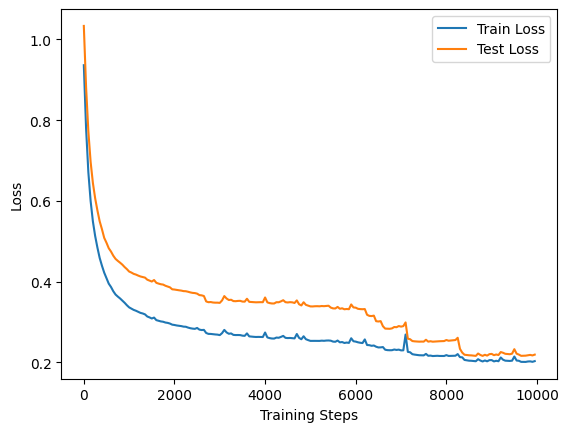

--- Clean data ---
Step 0, Train Loss: 1.2222834825515747, Test Loss: 1.069783329963684
Step 50, Train Loss: 0.8293638229370117, Test Loss: 0.6717708706855774
Step 100, Train Loss: 0.5308727025985718, Test Loss: 0.39638420939445496
Step 150, Train Loss: 0.43911460041999817, Test Loss: 0.3181445598602295
Step 200, Train Loss: 0.3911221921443939, Test Loss: 0.2728840112686157
Step 250, Train Loss: 0.3590555787086487, Test Loss: 0.24150070548057556
Step 300, Train Loss: 0.3099774122238159, Test Loss: 0.2189258337020874
Step 350, Train Loss: 0.3048332631587982, Test Loss: 0.21377676725387573
Step 400, Train Loss: 0.30024832487106323, Test Loss: 0.20943357050418854
Step 450, Train Loss: 0.2844569981098175, Test Loss: 0.1970367133617401
Step 500, Train Loss: 0.25085747241973877, Test Loss: 0.1687653660774231
Step 550, Train Loss: 0.22652532160282135, Test Loss: 0.15184876322746277
Step 600, Train Loss: 0.22206087410449982, Test Loss: 0.1476496160030365
Step 650, Train Loss: 0.199970260262489

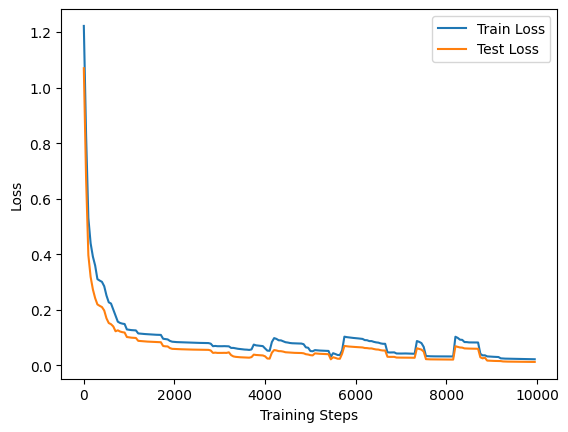

--- Clean data ---
Step 0, Train Loss: 1.120421051979065, Test Loss: 0.9908216595649719
Step 50, Train Loss: 0.8240751624107361, Test Loss: 0.7021805644035339
Step 100, Train Loss: 0.5476453304290771, Test Loss: 0.4301166534423828
Step 150, Train Loss: 0.4249700605869293, Test Loss: 0.30510586500167847
Step 200, Train Loss: 0.3582683205604553, Test Loss: 0.2629939615726471
Step 250, Train Loss: 0.346016526222229, Test Loss: 0.2497379332780838
Step 300, Train Loss: 0.34298601746559143, Test Loss: 0.24489659070968628
Step 350, Train Loss: 0.33300265669822693, Test Loss: 0.2410435825586319
Step 400, Train Loss: 0.3298477232456207, Test Loss: 0.23765136301517487
Step 450, Train Loss: 0.33298325538635254, Test Loss: 0.23695673048496246
Step 500, Train Loss: 0.3183785676956177, Test Loss: 0.22194793820381165
Step 550, Train Loss: 0.3149956166744232, Test Loss: 0.21785640716552734
Step 600, Train Loss: 0.31183910369873047, Test Loss: 0.21763165295124054
Step 650, Train Loss: 0.277667552232742

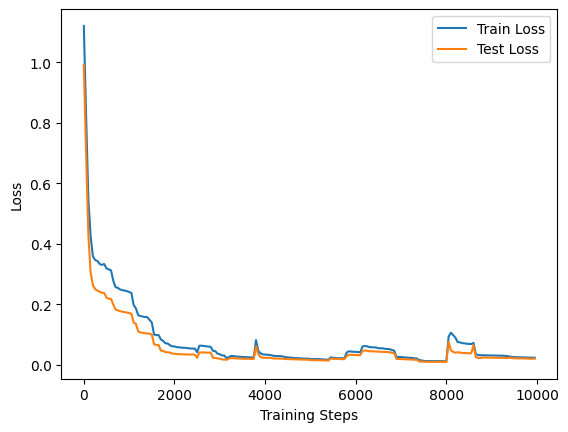

In [21]:
for dataset_name, (X_train, X_test, y_train, y_test) in processed_datasets.items():
    print(f'--- {name} ---')
    train_autoencoder(X_train, X_test)